In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

from sklearn.utils import shuffle

from tqdm.notebook import tqdm as tqdm
import time
import matplotlib.pyplot as plt
import time
import os
import copy
from natsort import natsorted as natsort
import random
import math
import cv2
from torch.backends import cudnn
# cudnn.benchmark = True # fast training
from torch.cuda.amp import autocast as autocast
import pandas as pd

plt.ion()   # interactive mode

In [22]:
from scipy.io import loadmat
from PIL import Image
from torch.utils.data import Dataset, DataLoader
# from prefetch_generator import BackgroundGenerator

In [23]:
train_path = '/home/tingwei/signboard/test/train' ## The path of train data

In [24]:
def func_DelFolder(path):
    
    if os.path.exists(path):
        
        for root, dirs, files in os.walk(path, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(path)
        
def func_CreateFolder(path):
    if os.path.exists(path):
        raise ValueError('Path exists!')
#     func_DelFolder(path)
    else:
        time.sleep(.300)
        os.mkdir(path)
    
print('done')

done


In [25]:
# pretrained_model = False
# path_temp = 'efficientnet-b7_%s' %(time.strftime("%Y_%b_%d_%H_%M", time.localtime()))
# start_time_save = time.strftime("%Y_%b_%d_%H_%M", time.localtime())
# if pretrained_model:
#     func_CreateFolder(save_folder_path)
#     path_temp = save_folder_path
# else:
#     func_CreateFolder(path_temp)
#     print('done')
# print(os.getcwd())
# print(path_temp)
path_temp = 'team_sixyeartaipeiman'
func_CreateFolder(path_temp)

ValueError: Path exists!

In [26]:
class DatasetLoader(Dataset):
    def __init__(self, df, transform, tag, label_dict):
        self.transform = transform
        self.tag = tag
        self.df = df
#         self.background_list = background_list
        self.tag = tag


        self.classes = list(label_dict.keys())
        self.class_to_idx = label_dict        

        
        self.data_list = list(self.df['0'])
        self.label_list = list(self.df['1'])
        if self.tag == 'train':
            shuffle(self.data_list, random_state = 0)
            shuffle(self.label_list, random_state = 0)

        images_names = self.data_list
        self.imgs = [(names, int(label_dict[self.label_list[i]])) for i, names in enumerate(images_names)]
        

    def __getitem__(self, index):
        imgpath, label = self.imgs[index]
    
        img = cv2.imread(imgpath)
    
    
    
        if self.transform is not None:
            if imgpath.split('/')[-3] == 'cleaned_data':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                kernel = np.ones((3,3), np.uint8)
                iter_erode = random.randint(1, 3)
                img = cv2.erode(img, kernel, iterations = iter_erode)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = Image.fromarray(img).convert('RGB')
            img = self.transform(img)
        return img, label

        
    def __len__(self):
        return len(self.imgs)

In [27]:
data_transforms = {'train':transforms.Compose([
                                            transforms.Resize((256, 256)),
                                              transforms.ToTensor(),
                                              ]),
                  'val':transforms.Compose([
                      transforms.Resize((256, 256)),
                      transforms.ToTensor(),

                      ]),
                  }

In [28]:
train_df = pd.read_csv(os.path.join(train_path, 'merge_training', 'merge_training_all_handwrite.csv'))
val_df = pd.read_csv(os.path.join(train_path, 'merge_training', 'merge_validation_all_handwrite.csv'))

In [29]:
all_data_list = list(train_df['0']) + list(val_df['0'])
all_label_list = list(train_df['1']) + list(val_df['1'])

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
all_label_list_encoded = labelencoder.fit_transform(all_label_list)

label_dict = {}
for i in range(len(all_label_list_encoded)):
    label_dict[all_label_list[i]] = all_label_list_encoded[i]

In [31]:
len(label_dict) #2520->5044

13134

In [32]:
balance_flag = False
image_datasets = {'train':DatasetLoader(train_df, data_transforms['train'], 'train', label_dict),
                 'val':DatasetLoader(val_df, data_transforms['val'], 'val', label_dict)
                 }

In [33]:
train_batch_size = 32
val_batch_size = 32
All_loader = {'train':DataLoader(dataset=image_datasets['train'], batch_size=train_batch_size, shuffle=True, num_workers=8, pin_memory=True),
             'val':DataLoader(dataset=image_datasets['val'], batch_size=val_batch_size, shuffle=False, num_workers=8,pin_memory=True),
             }

In [34]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 
                                                     'val', 
                                                    ]}
dataset_sizes

{'train': 722569, 'val': 9473}

In [35]:
class_names = image_datasets['train'].classes
class_names

['全',
 '花',
 '豐',
 '達',
 '窗',
 '簾',
 '祐',
 '成',
 '傢',
 '俱',
 '石',
 '理',
 '大',
 '雅',
 '裕',
 '廠',
 '昌',
 '盈',
 '水',
 '電',
 '五',
 '金',
 '材',
 '料',
 '行',
 '亞',
 '山',
 '具',
 '家',
 '茶',
 '板',
 '易',
 '白',
 '黑',
 '簧',
 '興',
 '三',
 '彈',
 '油',
 '壓',
 '嘉',
 '空',
 '民',
 '陳',
 '榔',
 '檳',
 '發',
 '批',
 '梅',
 '新',
 '木',
 '柚',
 '屋',
 '麗',
 '堃',
 '建',
 '工',
 '站',
 '國',
 '加',
 '簡',
 '桃',
 '壢',
 '中',
 '庭',
 '院',
 '法',
 '方',
 '地',
 '園',
 '身',
 '健',
 '輪',
 '泰',
 '有',
 '限',
 '司',
 '公',
 '份',
 '股',
 '胎',
 '璿',
 '斯',
 '福',
 '自',
 '助',
 '餐',
 '元',
 '廚',
 '動',
 '車',
 '美',
 '均',
 '產',
 '商',
 '冠',
 '業',
 '房',
 '租',
 '售',
 '用',
 '原',
 '忠',
 '駕',
 '班',
 '訓',
 '機',
 '械',
 '綸',
 '春',
 '稻',
 '制',
 '服',
 '和',
 '運',
 '華',
 '盟',
 '好',
 '聯',
 '品',
 '展',
 '子',
 '順',
 '振',
 '泉',
 '器',
 '控',
 '床',
 '唯',
 '墊',
 '義',
 '坊',
 '式',
 '麵',
 '燉',
 '飯',
 '利',
 '修',
 '區',
 '檢',
 '輛',
 '護',
 '心',
 '潞',
 '養',
 '辰',
 '切',
 '焊',
 '皓',
 '乙',
 '昶',
 '禾',
 '際',
 '宏',
 '東',
 '莊',
 '陽',
 '汽',
 '驗',
 '足',
 '館',
 '軒',
 '生',
 '七',
 '彩',
 '社',
 '善'

In [36]:
images,labels=next(iter(All_loader['train']))
images.shape,labels.shape
del images, labels

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = list(label_dict.keys())


def denormalize(image):
#     image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
    image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
    image = torch.clamp(image,0,1)
    image = torch.squeeze(image, 2)
    return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
#     plt.imshow(img, cmap='gray', vmin = 0, vmax = 1)
    plt.imshow(img, vmin = 0, vmax = 1)

In [38]:
def get_key (dict_, value):
    return [k for k, v in dict_.items() if v == value]

['鉶']
['電']
['暹']
['赶']
['禴']
['檁']
['啊']
['沊']
['衷']
['繘']
['謔']
['琩']
['啶']
['勿']
['迤']
['嫜']


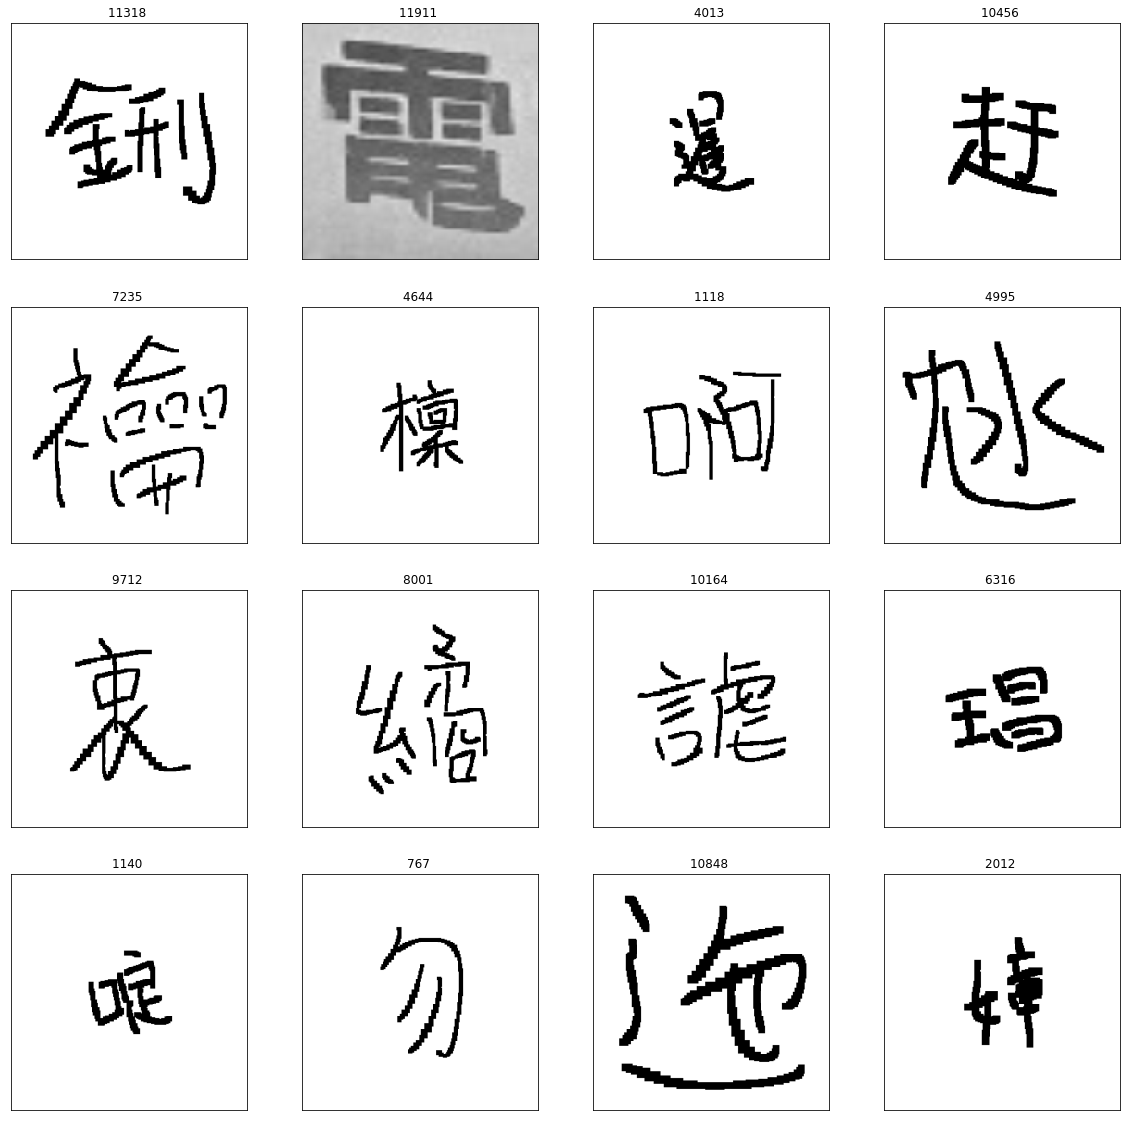

In [39]:
# obtain one batch of training images
dataiter = iter(All_loader['train'])
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 20))
# display 20 images
for idx in np.arange(16):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format(labels[idx]))
    print(get_key(label_dict, labels[idx]))
plt.savefig(os.path.join(path_temp, 'sample.png'))

In [40]:
device = torch.device('cuda')

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7', in_channels = 3, num_classes=max(all_label_list_encoded) + 1)

from torchsummary import summary
summary(model.cuda(), (3, 256, 256))

Loaded pretrained weights for efficientnet-b7
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 257, 257]               0
Conv2dStaticSamePadding-2         [-1, 64, 128, 128]           1,728
       BatchNorm2d-3         [-1, 64, 128, 128]             128
MemoryEfficientSwish-4         [-1, 64, 128, 128]               0
         ZeroPad2d-5         [-1, 64, 130, 130]               0
Conv2dStaticSamePadding-6         [-1, 64, 128, 128]             576
       BatchNorm2d-7         [-1, 64, 128, 128]             128
MemoryEfficientSwish-8         [-1, 64, 128, 128]               0
          Identity-9             [-1, 64, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 16, 1, 1]           1,040
MemoryEfficientSwish-11             [-1, 16, 1, 1]               0
         Identity-12             [-1, 16, 1, 1]               0
Conv2dStaticSamePadding-13        

In [41]:
from torch.optim import lr_scheduler
train_on_gpu = True
default_lr = 1e-4

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = default_lr)

In [42]:
train_on_gpu = True
sigmoid_version = False

scaler = torch.cuda.amp.GradScaler()

m = nn.Sigmoid()
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 20
train_loss_list = []
val_loss_list = []
train_step_loss_list = []
val_step_loss_list = []

train_acc_list = []
val_acc_list = []
lr_list = []

expansion_list = []

loss_flag  = 0
valid_loss_min = np.Inf # track change in validation loss
train_loss_min = np.Inf
valid_acc_max = 0
expansion = 0

lr_decrease_flag = False

#train_losses,valid_losses=[],[]
start_time = time.time()

t_p_step_loss = []
t_n_step_loss = []
v_p_step_loss = []
v_n_step_loss = []

iter_i = 0

for epoch in tqdm(range(1, n_epochs+1)):
    

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_accuracy_count = 0
    train_count = 0
    
    val_accuracy_count = 0
    val_count = 0
    loss_count = 0
    print('running epoch: {}'.format(epoch))

    ###################
    # train the model #
    ###################
    model.train()
    if epoch == 2:
        end_time = time.time()
        print('Predict Spend Time = ', str((end_time - start_time) / 3600 * n_epochs),' hr')
        
    accumulate_i = 0
    accumulation_steps = 100
    for data, target in tqdm(All_loader['train']):
        iter_i += 1

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
#         with torch.no_grad():

        with autocast():
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss and accuracy


            loss = criterion(output, target)
                
        if sigmoid_version:
            predicted = output.data
            predicted[predicted>=0.5]=1
            predicted[predicted<0.5]=0
            predicted = torch.squeeze(predicted, 1)
        else:
            _, predicted = torch.max(output.data, 1)
                    
        train_count += len(data)
        train_accuracy_count += (predicted == target).sum().item()
        train_accuracy = train_accuracy_count / train_count
        
        train_step_loss_list.append(loss.item())

        # backward pass: compute gradient of the loss with respect to model parameters
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()
    
        # update training loss
        train_loss += loss.item() * data.size(0)
    
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(All_loader['val']):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model

            output = model(data)

            # calculate the batch loss and accuracy
            loss = criterion(output, target)

            if sigmoid_version:
                predicted = output.data
                predicted[predicted>=0.5]=1
                predicted[predicted<0.5]=0
                predicted = torch.squeeze(predicted, 1)
            else:
                _, predicted = torch.max(output.data, 1)

            val_count += len(data)
            val_accuracy_count += (predicted == target).sum().item()
            val_accuracy = val_accuracy_count / val_count
            val_step_loss_list.append(loss.item())
            # update average validation loss 
            valid_loss += loss.item() * data.size(0)

        train_loss = train_loss/train_count
        valid_loss = valid_loss/val_count
        

        

    print('epoch:'+str(epoch)+'-loss = {:.6f}'.format(train_loss),'-',
          'accuracy = {:.2f}%'.format(100.*train_accuracy),'-',
          'Validation loss = {:.6f}'.format(valid_loss),'-',
          'validation_accuracy = {:.2f}%'.format(100.*val_accuracy))
    
    if valid_loss <= valid_loss_min:
        loss_flag  = 0
        model_name = 'best_model.pth'
        print('Validation loss decreased from ({:.6f} --> {:.6f}).  Saving model '.format(valid_loss_min, valid_loss)+str(model_name)+'\n')

        torch.save(model.state_dict(), os.path.join(path_temp, model_name))

        
        valid_loss_min = valid_loss 
        
    else:
        loss_flag += 1
        if loss_flag == 5:
            lr_decrease_flag = True
        print('Validation loss did not decrease from ({:.6f}).'.format(valid_loss_min))

running epoch: 1


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), os.path.join(path_temp,'last_epoch_model'))